In [1]:
import sys, os
if 'google.colab' in sys.modules and not os.path.exists('.setup_complete'):
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh -O- | bash
    !touch .setup_complete

# This code creates a virtual display to draw game images on.
# It will have no effect if your machine has a monitor.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Starting virtual X frame buffer: Xvfb.


In [2]:
import gymnasium as gym
import numpy as np
import random
import matplotlib.pyplot as plt
import collections

import torch
import torch.nn as nn
import torch.optim as optim

from IPython import display

%matplotlib inline

In [3]:
#Создаём среду

env = gym.make("FrozenLake-v1", is_slippery=False, render_mode="rgb_array")

In [4]:
# Гиперпараметры

GAMMA = 0.99
LR = 0.001
EPSILON = 1.0
EPSILON_DECAY = 0.995
EPSILON_MIN = 0.01
BATCH_SIZE = 64
MEMORY_SIZE = 10000
TARGET_UPDATE = 10
EPISODES = 1000

In [5]:
# Определяем нейросеть для DQN

class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )

    def forward(self, x):
        return self.fc(x)

In [6]:
# Определяем буфер воспроизведения

class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity) # Инициализируйте буфер. Можете воспользоваться deque

    def add(self, transition):
        self.buffer.append(transition) # Напишите добавление перехода (state, action, reward, next_state) в буфер

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states = zip(*batch)
        return states, actions, rewards, next_states # Напишите выбор случайного батча переходов из буфера

    def __len__(self):
        return len(self.buffer)

In [7]:
# Инициализируйте 2 сети агента и буфер с помощью написанных классов

input_dim = env.observation_space.n
output_dim = env.action_space.n

# Сеть должна получать на вход one hot encoded вектор состояния и возвращать вектор Q значений для каждого действия
policy_net = DQN(input_dim, output_dim)
target_net = DQN(input_dim, output_dim)
target_net.load_state_dict(policy_net.state_dict())  # Копируем веса
optimizer = optim.Adam(policy_net.parameters(), lr=LR)
memory = ReplayBuffer(MEMORY_SIZE)

In [8]:
# Напишите функцию выбора действия для epsilon жадной стратегии. Не забудьте преобразовать state для нейросети

def select_action(state, epsilon):
    if random.random() < epsilon:
        return env.action_space.sample()
    else:
        with torch.no_grad():
            state_one_hot = torch.zeros(input_dim)
            state_one_hot[state] = 1
            return policy_net(state_one_hot).argmax().item()

In [9]:
# Напишите функцию обновления сети
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return

    batch = memory.sample(BATCH_SIZE)
    states, actions, rewards, next_states = batch

    # Преобразуем состояния и следующие состояния в one-hot векторы
    states_one_hot = torch.zeros(BATCH_SIZE, input_dim)
    states_one_hot[np.arange(BATCH_SIZE), states] = 1

    next_states_one_hot = torch.zeros(BATCH_SIZE, input_dim)
    next_states_one_hot[np.arange(BATCH_SIZE), next_states] = 1

    actions = torch.LongTensor(actions)
    rewards = torch.FloatTensor(rewards)

    current_q_values = policy_net(states_one_hot).gather(1, actions.unsqueeze(1))
    next_q_values = target_net(next_states_one_hot).max(1)[0].detach()
    expected_q_values = rewards + GAMMA * next_q_values

    loss = nn.MSELoss()(current_q_values.squeeze(), expected_q_values)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


In [10]:
# Цикл обучения

for episode in range(EPISODES):
    state = env.reset()[0]
    total_reward = 0

    while True:
        action = select_action(state, EPSILON)
        next_state, reward, done, truncated, _ = env.step(action)
        memory.add((state, action, reward, next_state)) # Добавьте переход в буфер

        state = next_state
        total_reward += reward

        optimize_model() # Обновите модель

        if done or truncated:
            break

    EPSILON = max(EPSILON * EPSILON_DECAY, EPSILON_MIN)

    if episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict()) # Скопируйте веса модели в таргет сеть

    if episode % 100 == 0:
        print(f"Эпизод {episode}: Награда {total_reward}")

Эпизод 0: Награда 0.0
Эпизод 100: Награда 0.0
Эпизод 200: Награда 0.0
Эпизод 300: Награда 0.0
Эпизод 400: Награда 0.0
Эпизод 500: Награда 0.0
Эпизод 600: Награда 0.0
Эпизод 700: Награда 0.0
Эпизод 800: Награда 0.0
Эпизод 900: Награда 0.0


0.0


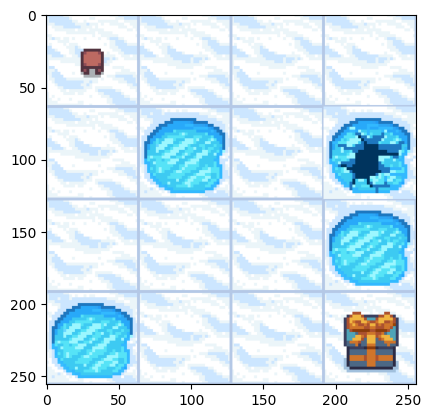

In [11]:
display.clear_output(wait=True)
state = env.reset()[0]
done = False
total_reward = 0
print(f"Эпизод {episode + 1}:")
while not done:
    action = select_action(state, epsilon=0)
    state, reward, done, _, _ = env.step(action)  # Действуем жадно
    total_reward += reward
    plt.imshow(env.render())

    display.display(plt.gcf())
    display.clear_output(wait=True)
print(total_reward)